<a href="https://colab.research.google.com/github/abhay43/DL_Code/blob/master/human_pose_detection_using_maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
def unzipme(location):
  import zipfile
  with zipfile.ZipFile(location) as zip_ref:
    zip_ref.extractall()
    print('done')


In [4]:
unzipme('/content/drive/My Drive/Colab Notebooks/Dataset - Human Pose Estimation')

done


In [5]:
unzipme('/content/Pose_Dataset.zip')


done


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [7]:
!pip uninstall keras

Uninstalling Keras-2.3.1:
  Would remove:
    /tensorflow-1.15.2/python3.6/Keras-2.3.1.dist-info/*
    /tensorflow-1.15.2/python3.6/docs/*
    /tensorflow-1.15.2/python3.6/keras/*
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1


In [8]:
!pip install q keras==2.1.0

     |████████████████████████████████| 307kB 3.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [10]:
cd Mask_RCNN

/content/Mask_RCNN


In [11]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/

In [12]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


In [13]:
pwd

'/content/Mask_RCNN'

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [145]:
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from numpy import asarray 
class PoseDetection(Dataset):

  def load_csv(self, data_dir, isTrain = False):
    if(isTrain):
      data = pd.read_csv(data_dir+'/train_joints_coords.csv', header=None, index_col=[0])
    else:
      data = pd.read_csv(data_dir+'/test_joints_coords.csv', header = None, index_col=[0])
    return data    
    
  def load_dataset(self, data_dir, isTrain = False):
    # Added the class
    pose_name = ['left shoulder', 'left elbow', 'left wrist', 'right shoulder', 'right elbow', 'right wrist', 'left eye','right eye', 'nose']
    counter = 0
    for s in pose_name:
      self.add_class("dataset", counter+1, pose_name[counter])
      counter = counter +1
    train_image_dir =data_dir+'/train/'
    test_image_dir =data_dir+'/test/' 
    if(isTrain): 
      for train_dir in listdir(train_image_dir):
        image_id = train_dir
        image_path = train_image_dir+train_dir
        self.add_image('dataset', image_id=image_id, path=image_path)
    else:
      for test_dir in listdir(test_image_dir):
        image_id = test_dir
        image_path = test_image_dir+image_id
        self.add_image('dataset', image_id=image_id, path=image_path)

    

  #  data = self.load_csv(data_dir, isTrain)    
    # return_data = list()
    # dir = ''
    # if(isTrain):
    #   dir = data_dir+'/train/'
    # else:
    #   dir = data_dir+'/test/'
    # for i, d in data.iterrows():      
    #     lstdata = plt.imread(dir+str(i))
    #     return_data.append(lstdata)
    # return return_data

  def extract_points(self, data_dir, image_id, isTrain= False):
    if(isTrain):
      dir = data_dir+'/train/'
    else:
      dir = data_dir+'/test/'
    myimg = plt.imread(dir+image_id)
    w, h, z = myimg.shape
    data = self.load_csv(data_dir, isTrain) 
    lstData= list(data.loc[image_id]) 
    returnData = list()
    for i,d in enumerate(lstData):
      if(i%2 != 1):
        continue
      else:
        data = (lstData[i], lstData[i-1])
        returnData.append(data)
    return returnData, w, h ,z

  # def load_mask(self,data_dir,train_data, image_id, isTrain= False ):
  def load_mask(self, image_id):
    info = self.image_info[image_id]
    isTrain = False
    data_dir = '/content/Pose_Dataset'
    image_id_str = info['id']
    if('train' in image_id_str):
      isTrain = True 
    masked_points, w, h,z = self.extract_points(data_dir, image_id_str, isTrain)
    masks = np.zeros((w,h,z), dtype='uint8')
    pose_name = ['left shoulder', 'left elbow', 'left wrist', 'right shoulder', 'right elbow', 'right wrist', 'left eye','right eye', 'nose']
    class_ids = list()
    counter = 0
    for i in masked_points:
      masks[i] = 1
      class_ids.append(self.class_names.index(pose_name[counter]))
      counter = counter+1
    return masks, asarray(class_ids, dtype='int32')
      
    


In [146]:
train_cls = PoseDetection()
train_cls.load_dataset('/content/Pose_Dataset', True)
train_cls.prepare()
print('Train: %d' % len(train_cls.image_ids))

Train: 4429


In [147]:
test_cls = PoseDetection()
test_cls.load_dataset('/content/Pose_Dataset', False)
test_cls.prepare()
print('Test: %d' % len(test_cls.image_ids))

Test: 574


In [150]:
image_id = 29
image = train_cls.load_image(image_id)
print(train_cls.image_info[image_id])
# load image mask
mask, class_ids = train_cls.load_mask(image_id)
print(mask.shape)

{'id': 'train2235.jpg', 'source': 'dataset', 'path': '/content/Pose_Dataset/train/train2235.jpg'}
(224, 224, 3)


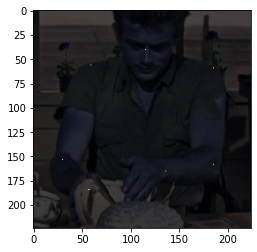

In [151]:
from matplotlib import pyplot
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.7)
pyplot.show()

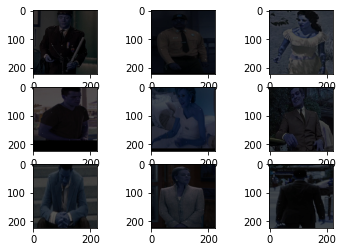

In [153]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_cls.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_cls.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()